# Tech Team Ticket Metrics

In [4]:
# SPDX-License-Identifier: Apache-2.0
# Licensed to the Ed-Fi Alliance under one or more agreements.
# The Ed-Fi Alliance licenses this file to you under the Apache License, Version 2.0.
# See the LICENSE and NOTICES files in the project root for more information.

from edfi_tech_metrics.settings import load_from_env
from edfi_tech_metrics.jira import JiraBrowser
from edfi_tech_metrics.ticket_age import build_report_components

conf = load_from_env()
#conf.log_level = "DEBUG"
browser = JiraBrowser(conf)

portfolios = {
    "ODS Platform": ["ODS"],
    "Team B": ["METAED", "DMS", "ADMINAPI"],
    "Ed-Fi Tools": ["AA", "AC", "APIPUB", "DI", "EPPETA"],
    "Data Standard": [ "DATASTD", "MODL", "TPDMDEV"],
    "Support": ["EDFI"]
}

# DSOPS and TPDMX appear to be unused, removing those from Data Standard

projects = [i for _, v in portfolios.items() for i in v]
df = browser.get_unresolved_tickets(projects)

Connecting to https://tracker.ed-fi.org
Retrieving tickets for ODS
Retrieving tickets for METAED
Retrieving tickets for DMS
Retrieving tickets for ADMINAPI
Retrieving tickets for AA
Retrieving tickets for AC
Retrieving tickets for APIPUB
Retrieving tickets for DI
Retrieving tickets for EPPETA
Retrieving tickets for DATASTD
Retrieving tickets for MODL
Retrieving tickets for TPDMDEV
Retrieving tickets for EDFI


## Ticket Age

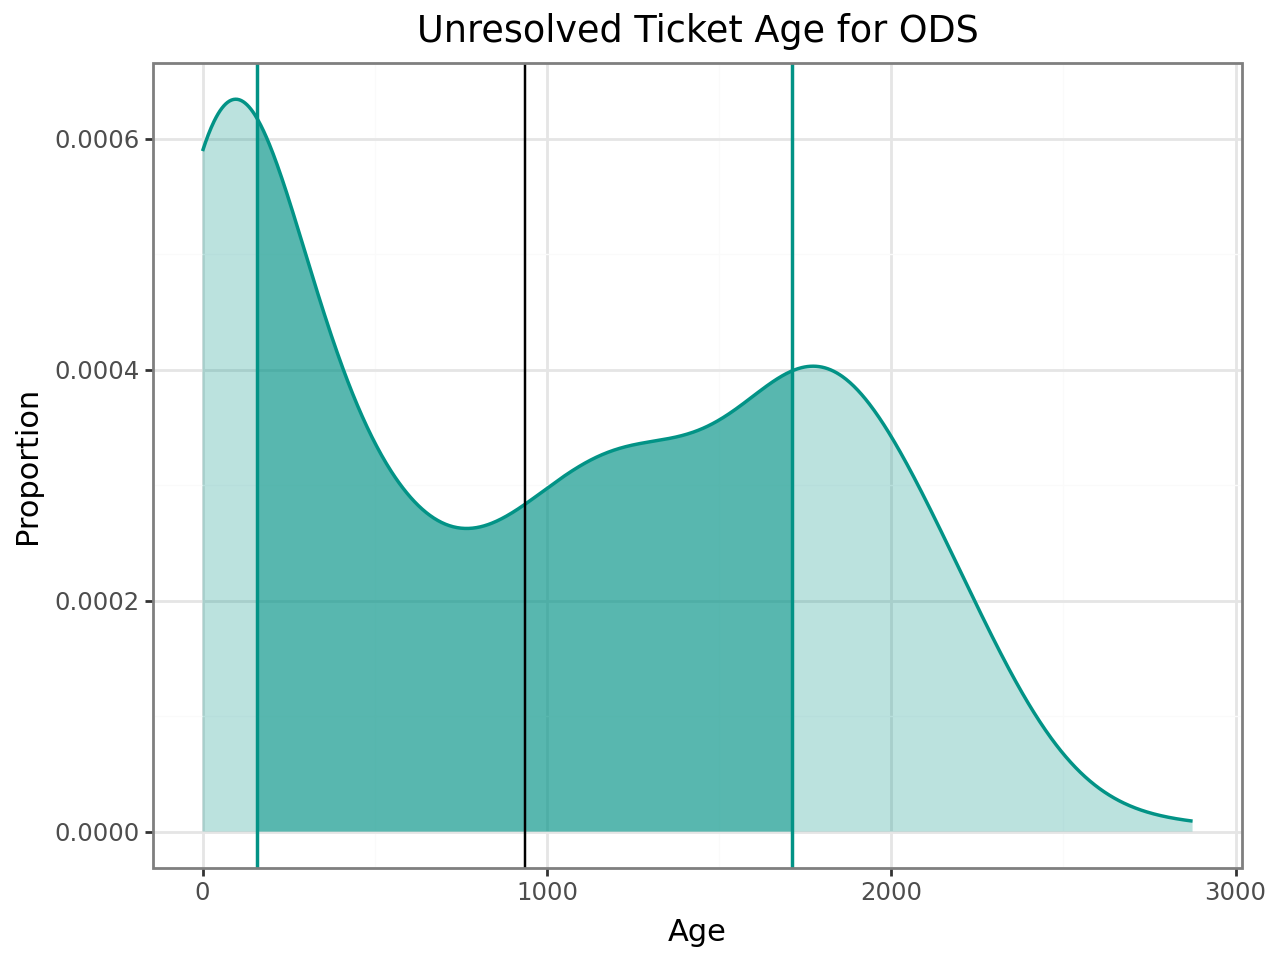

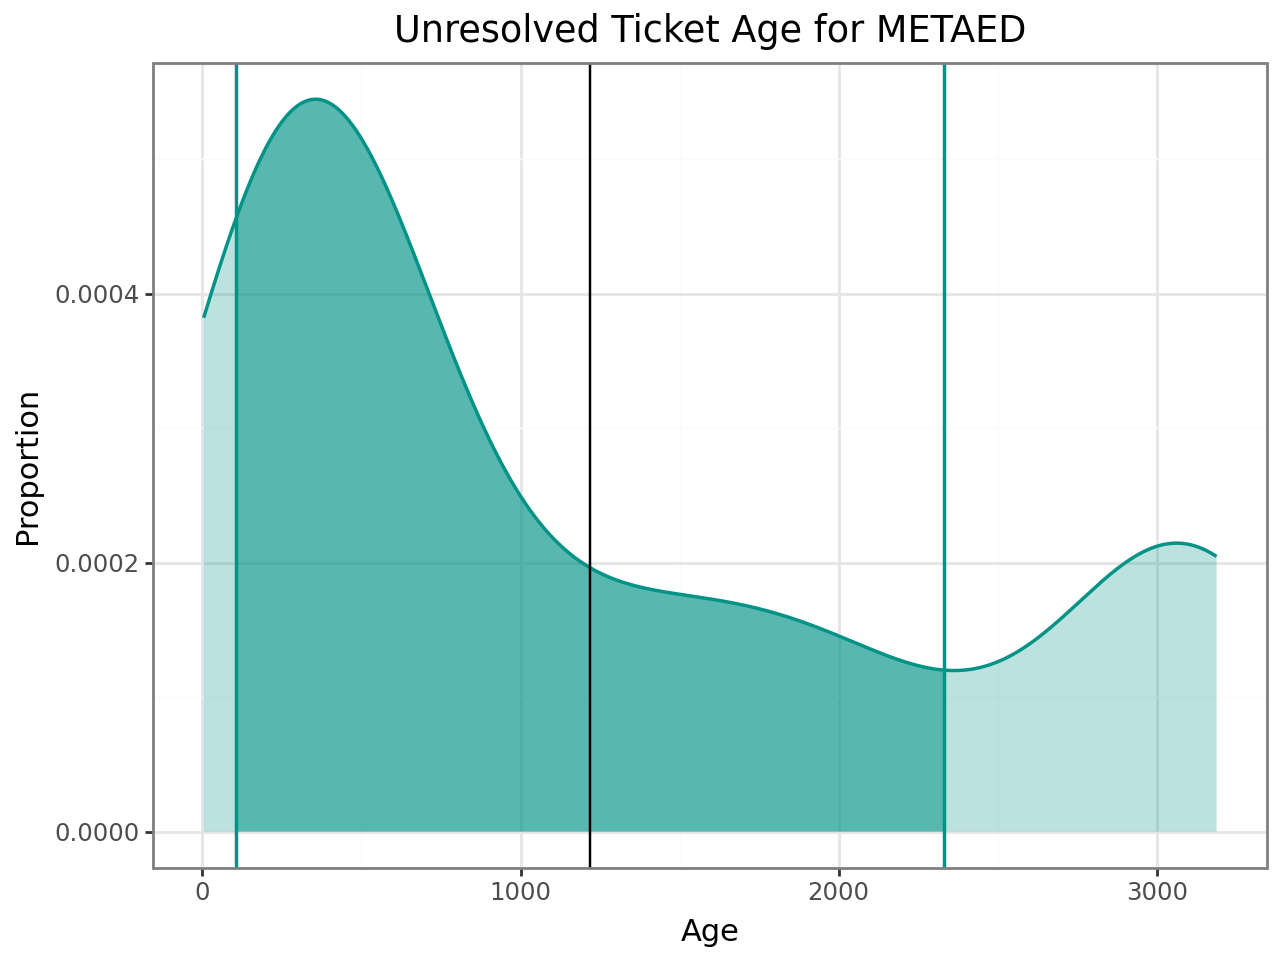

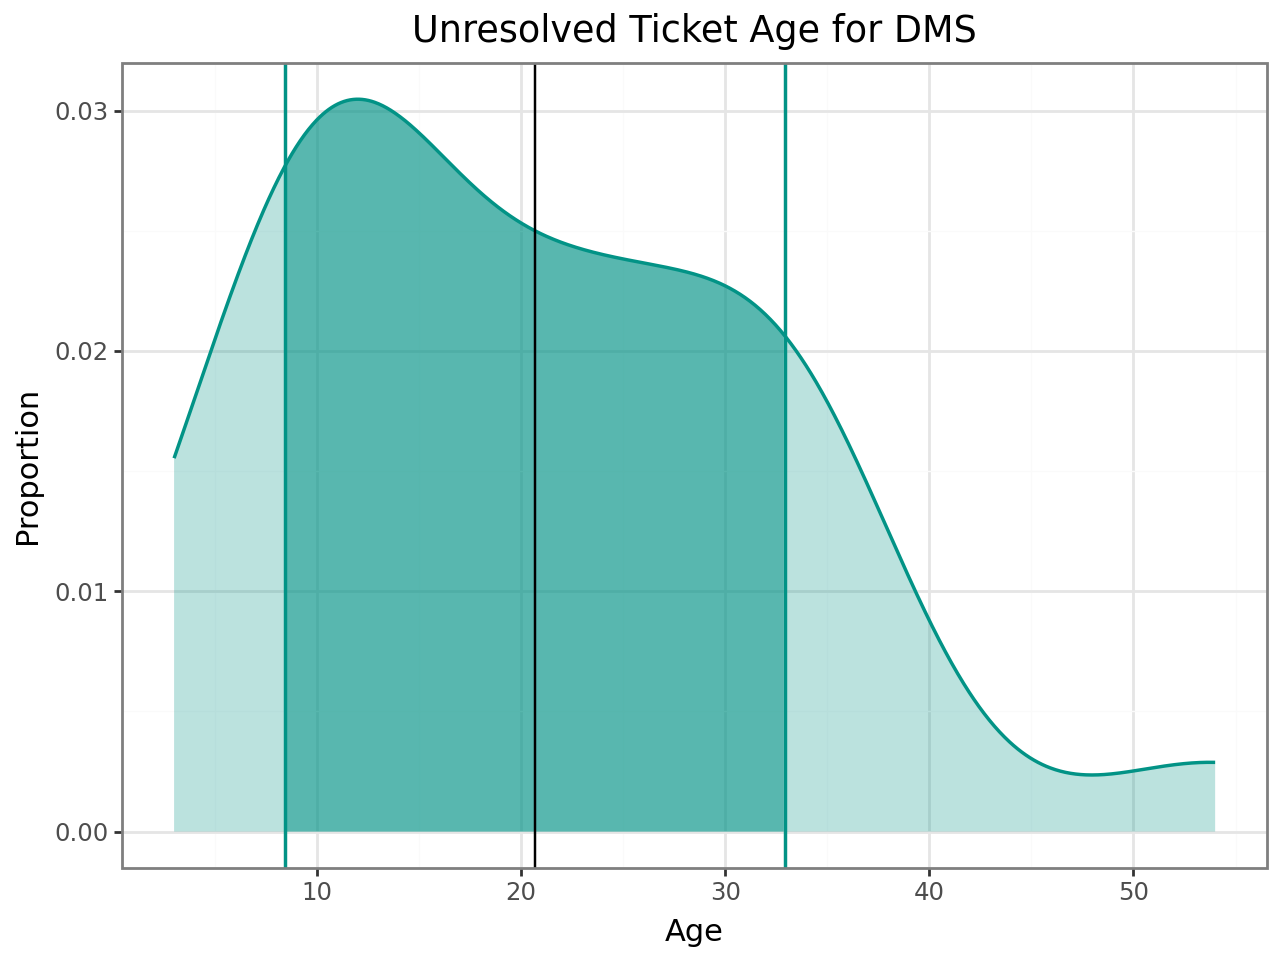

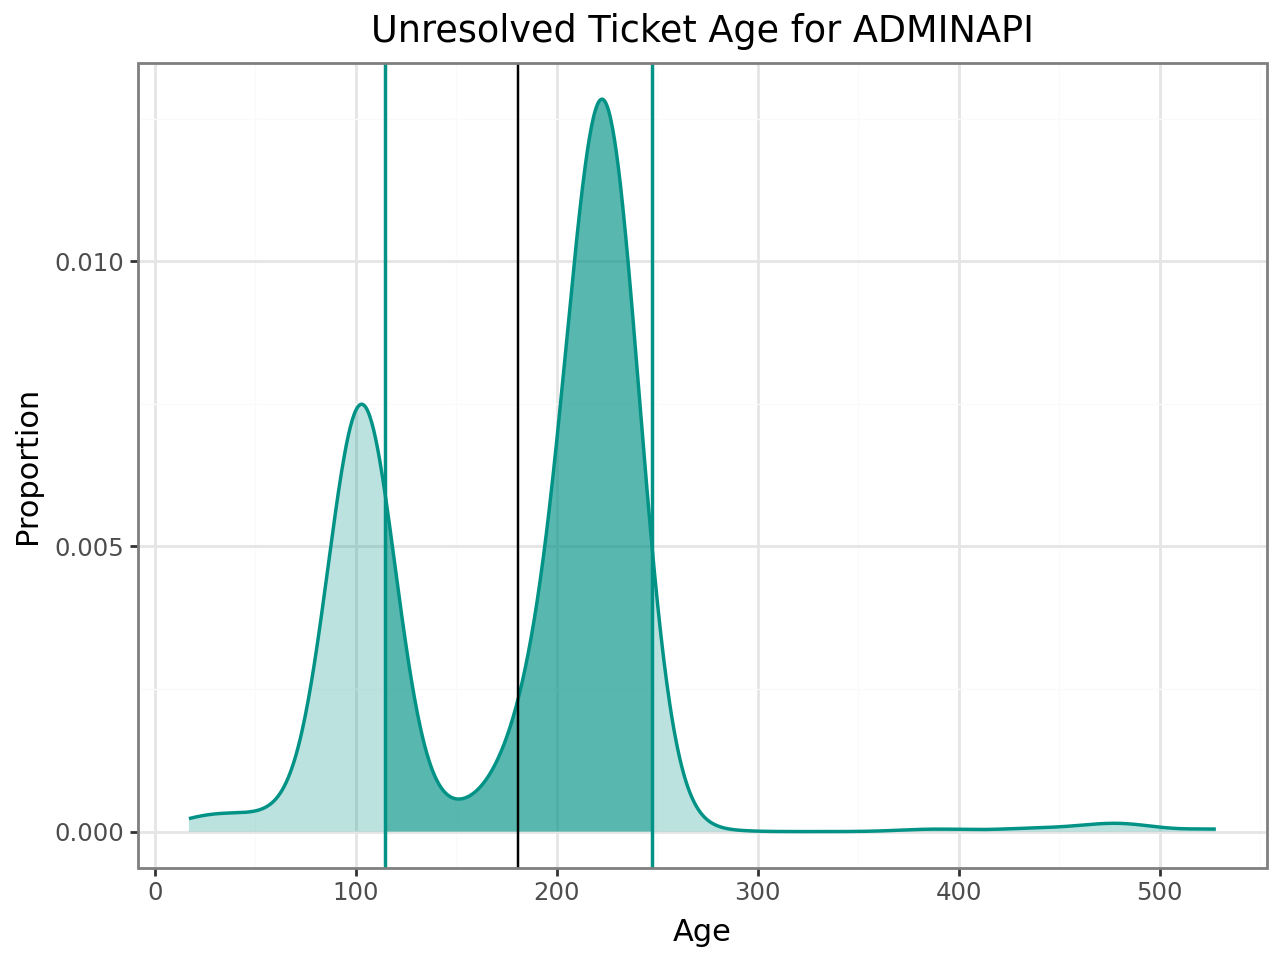

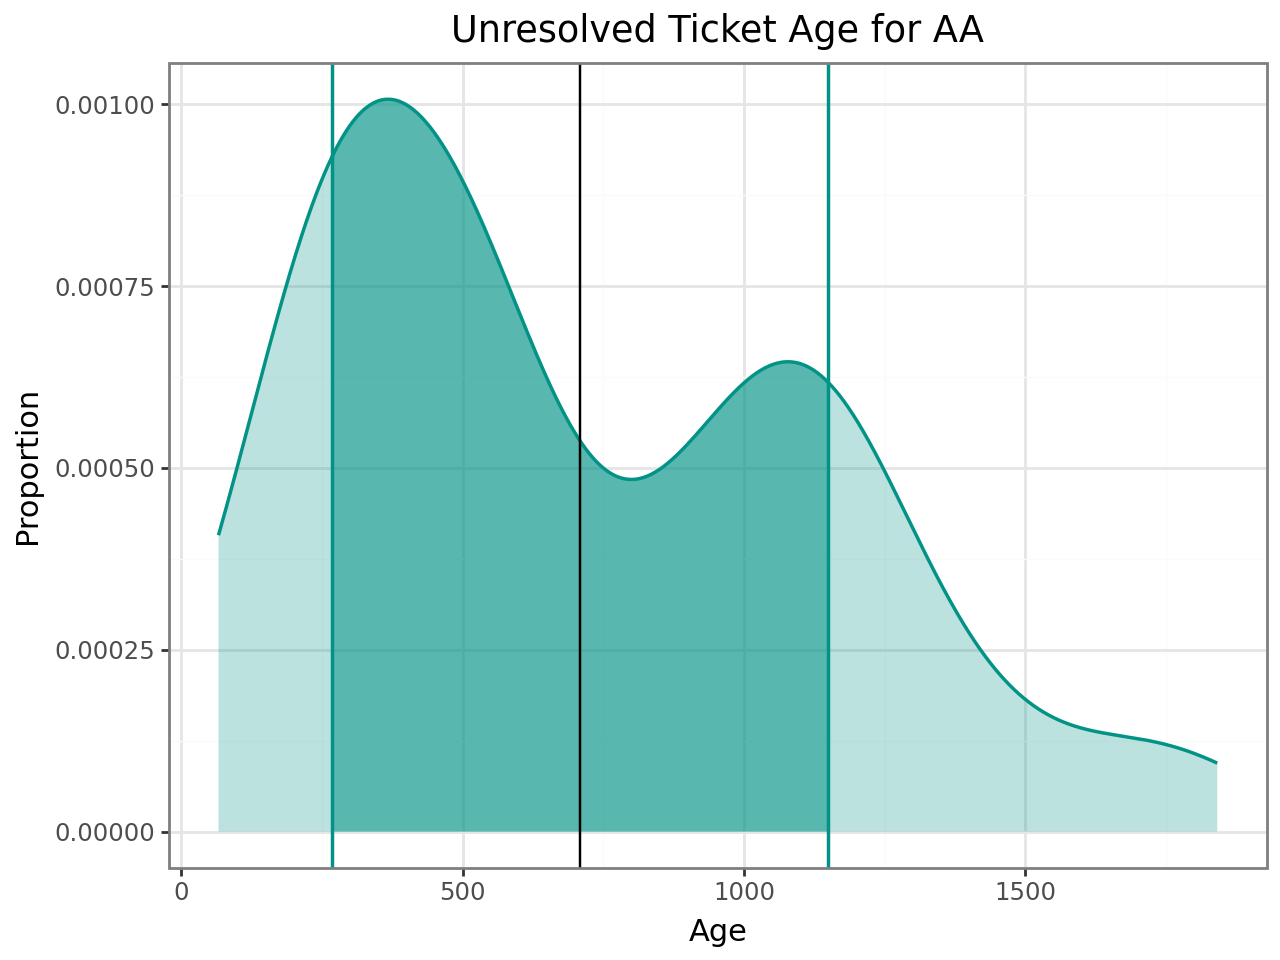

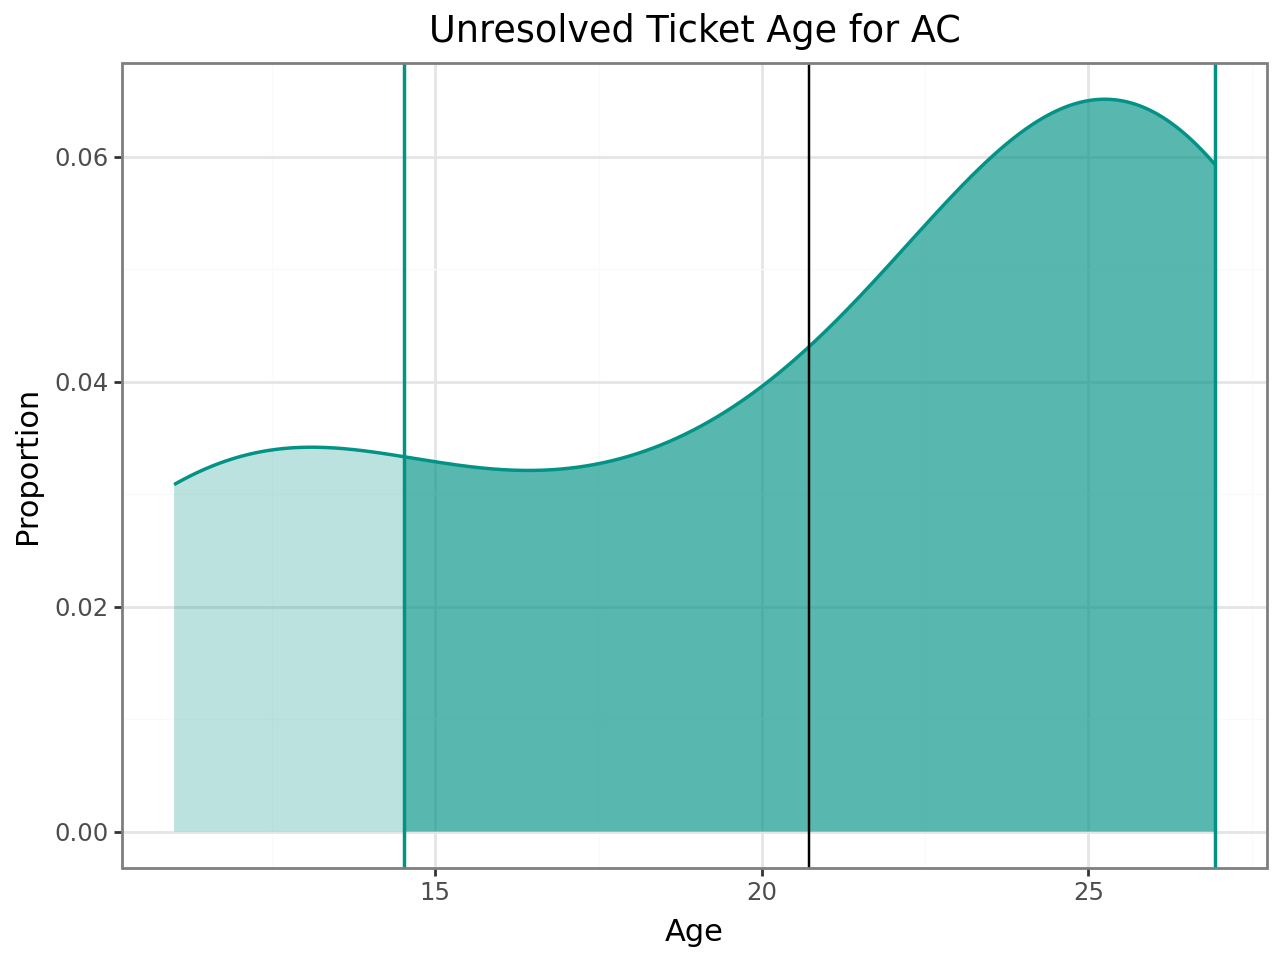

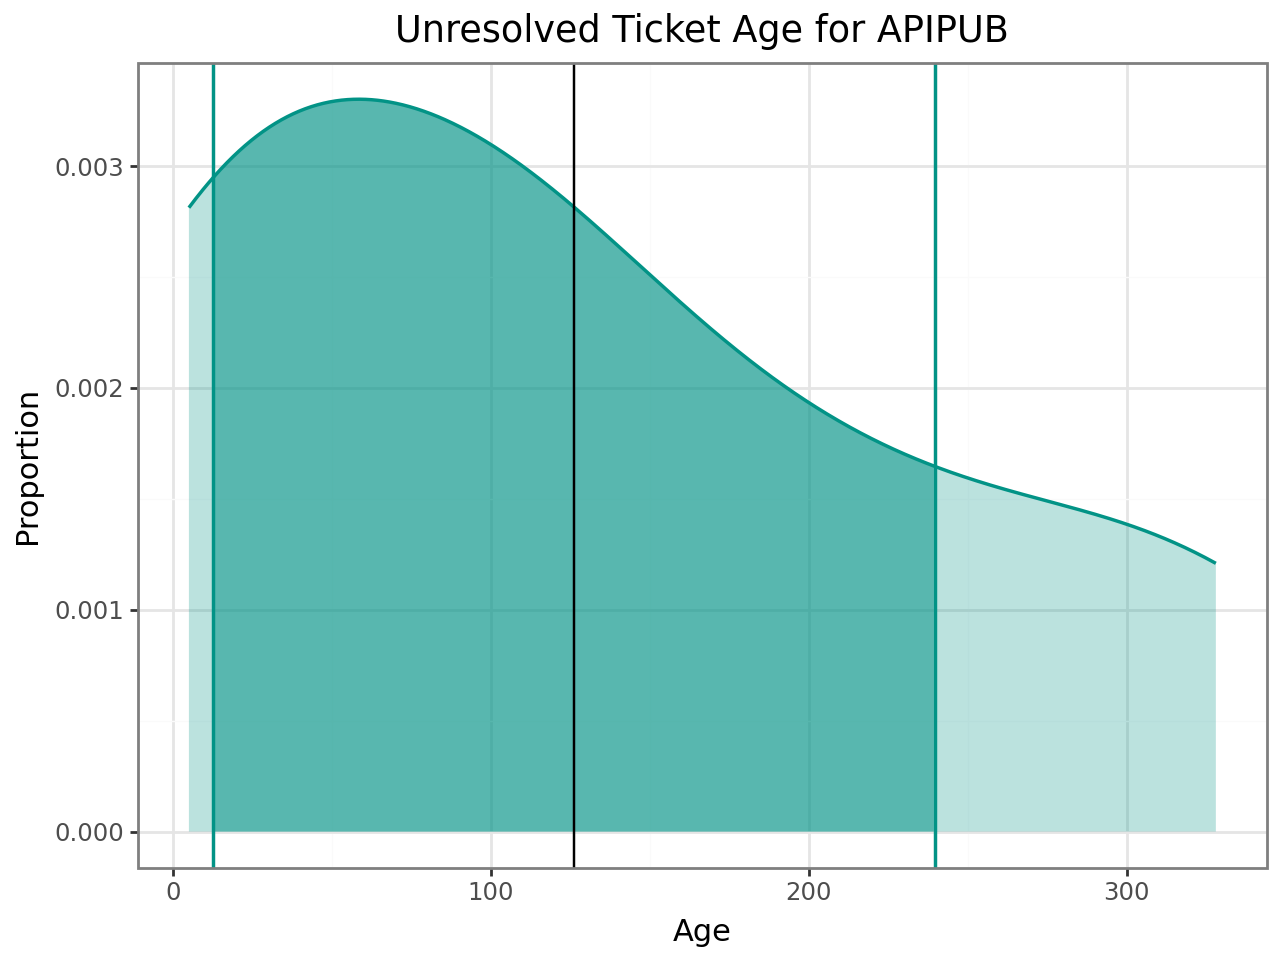

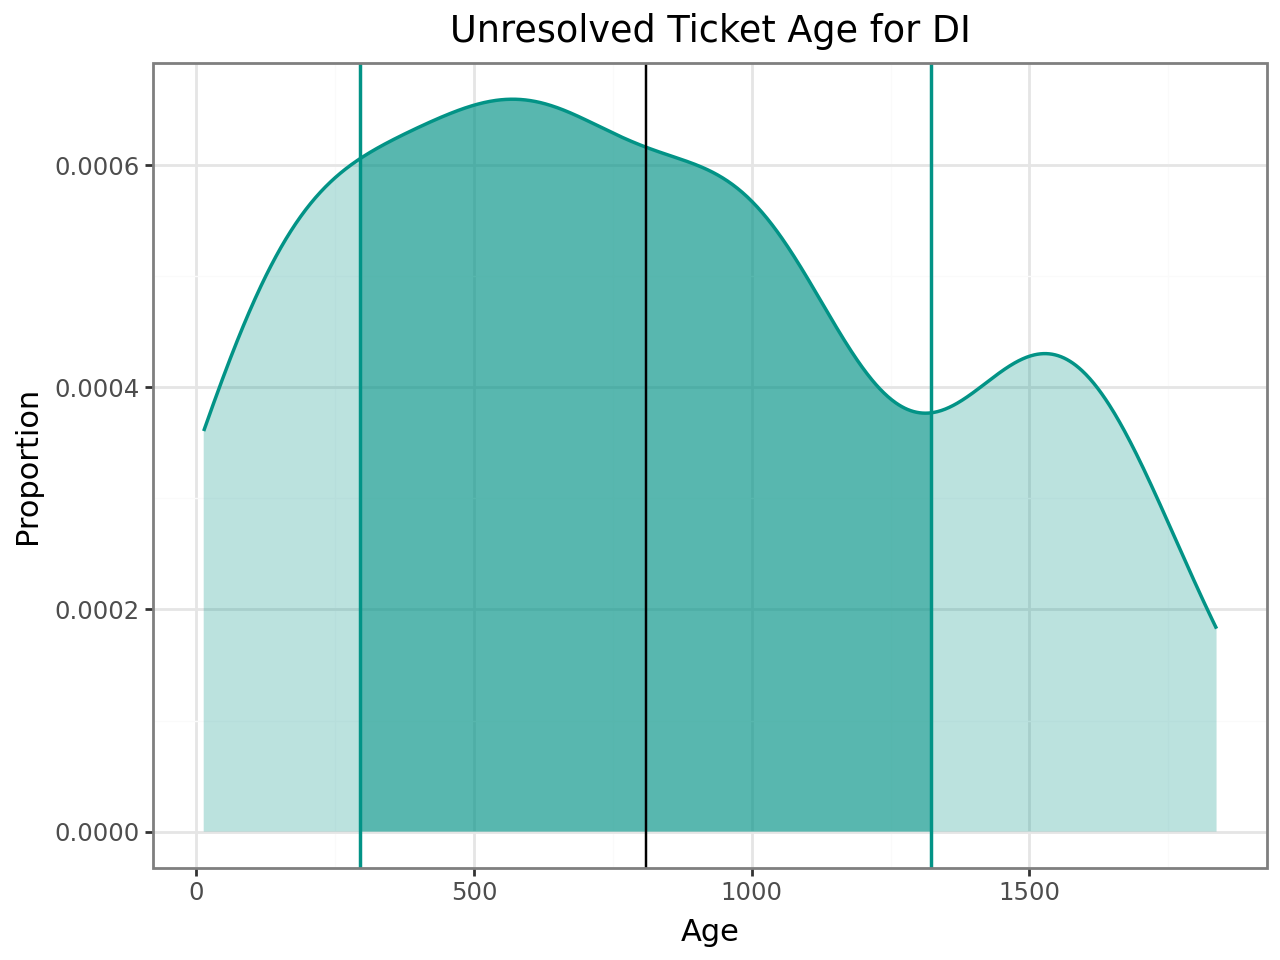

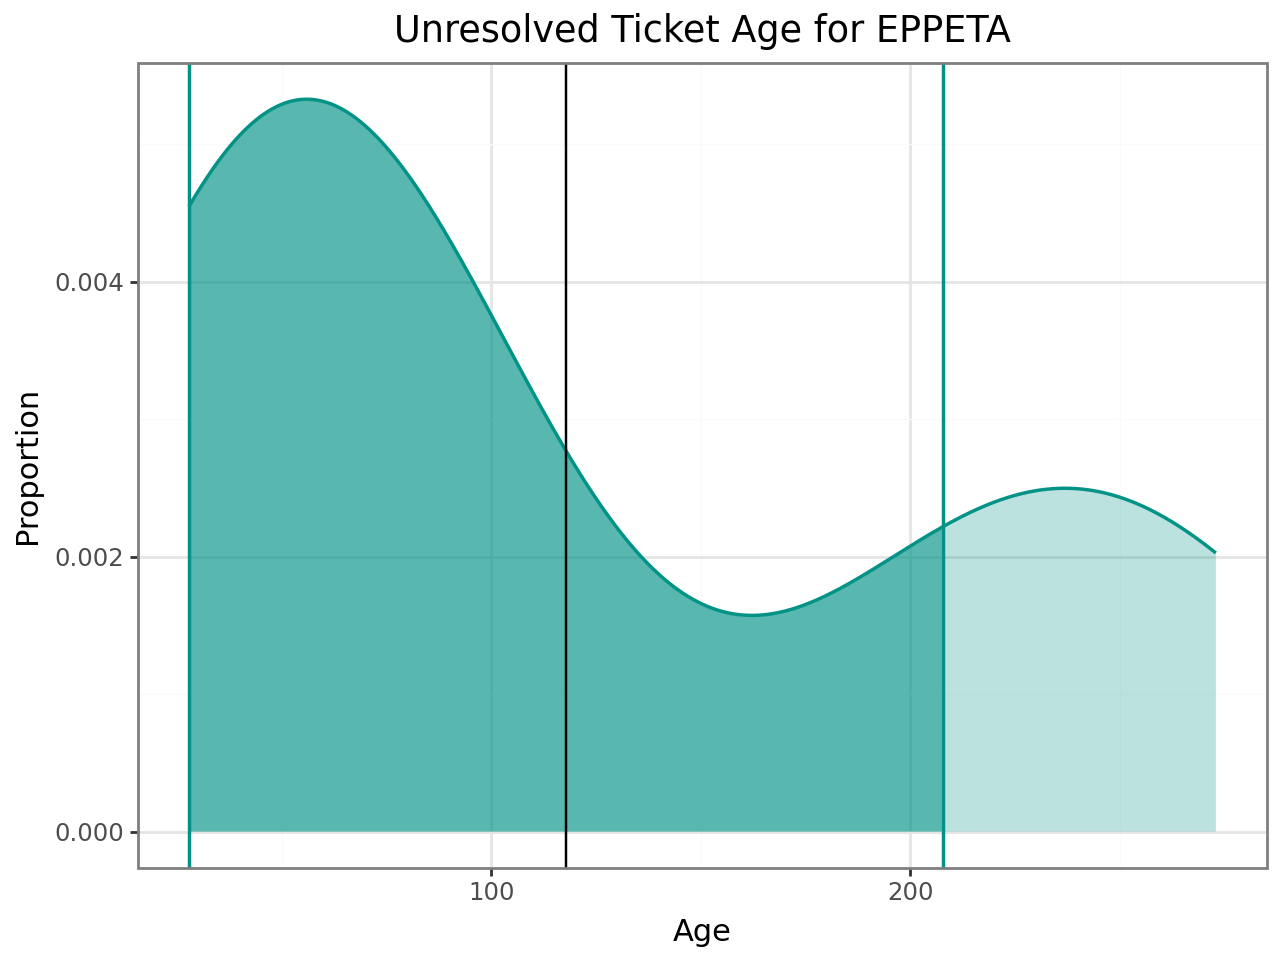

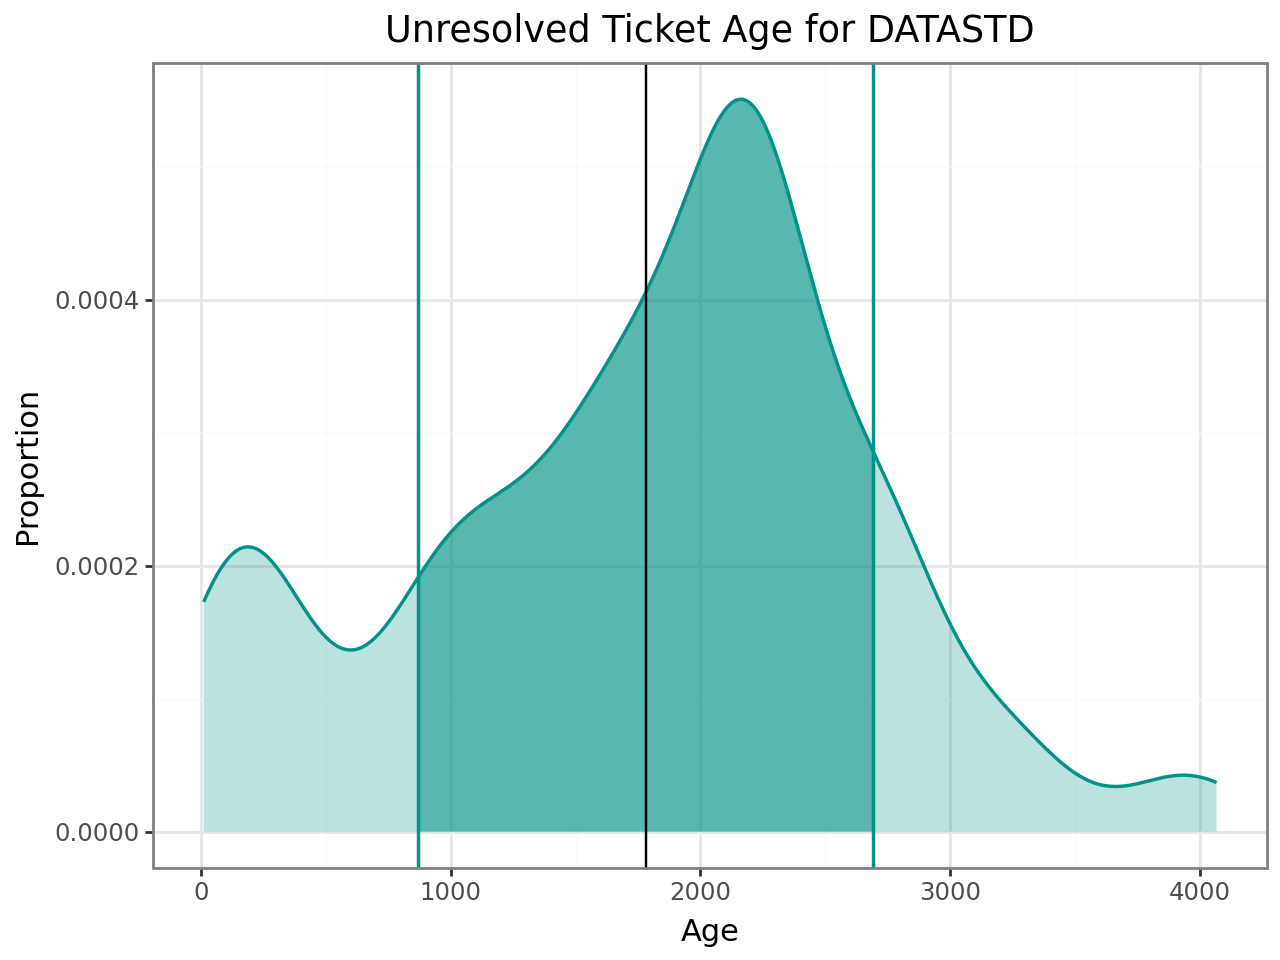

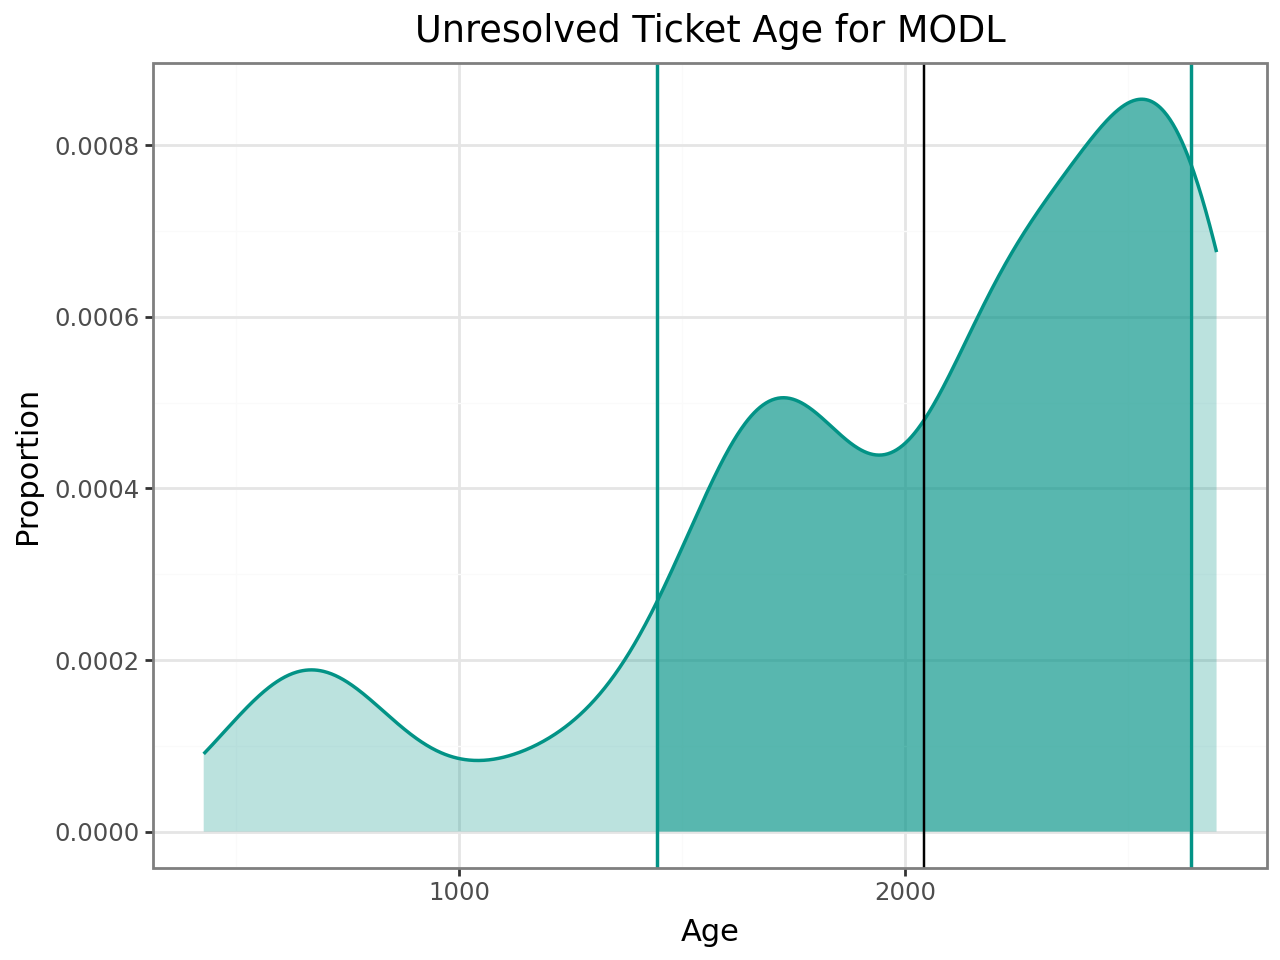

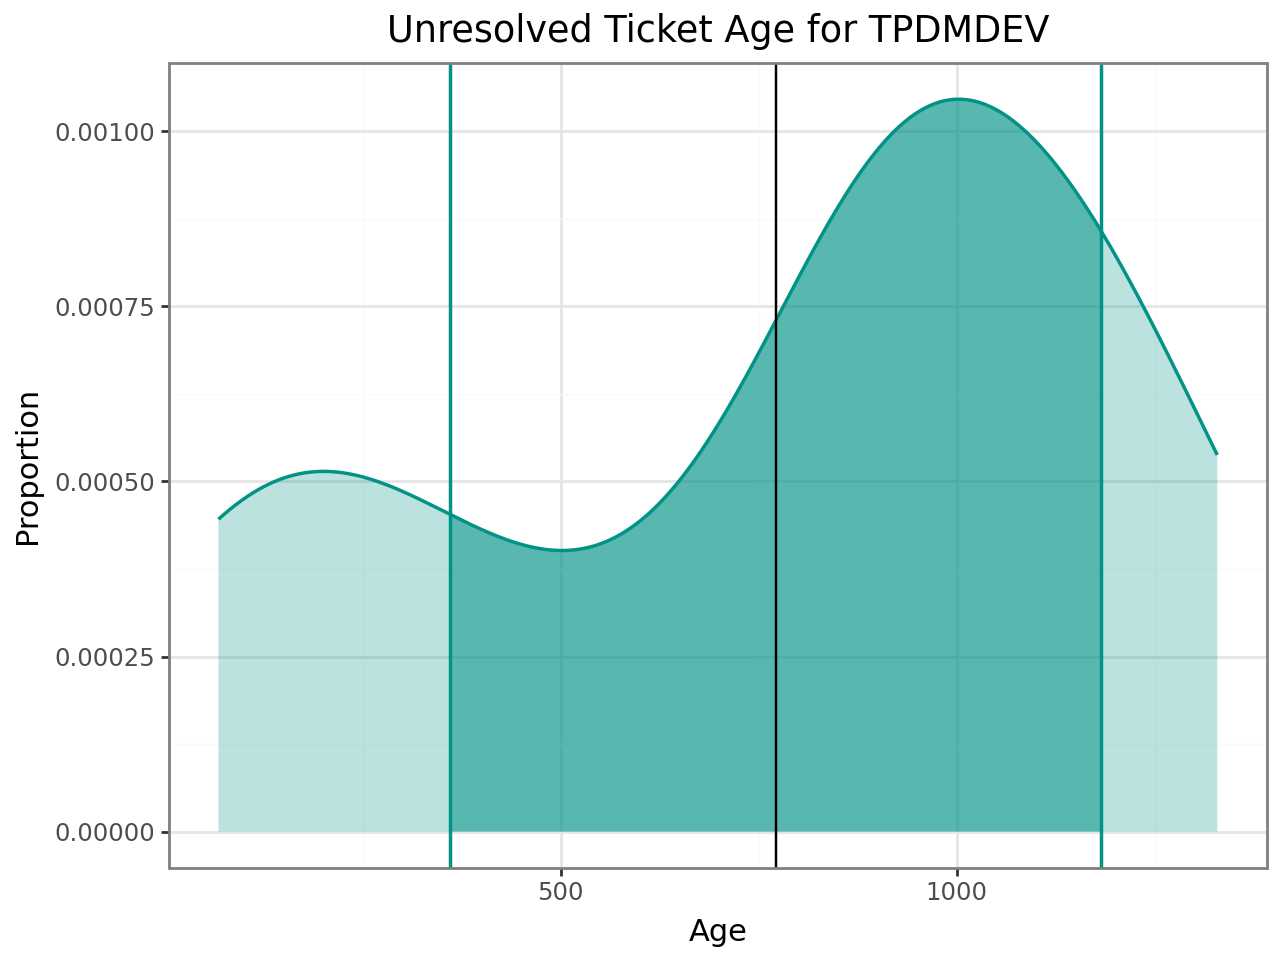

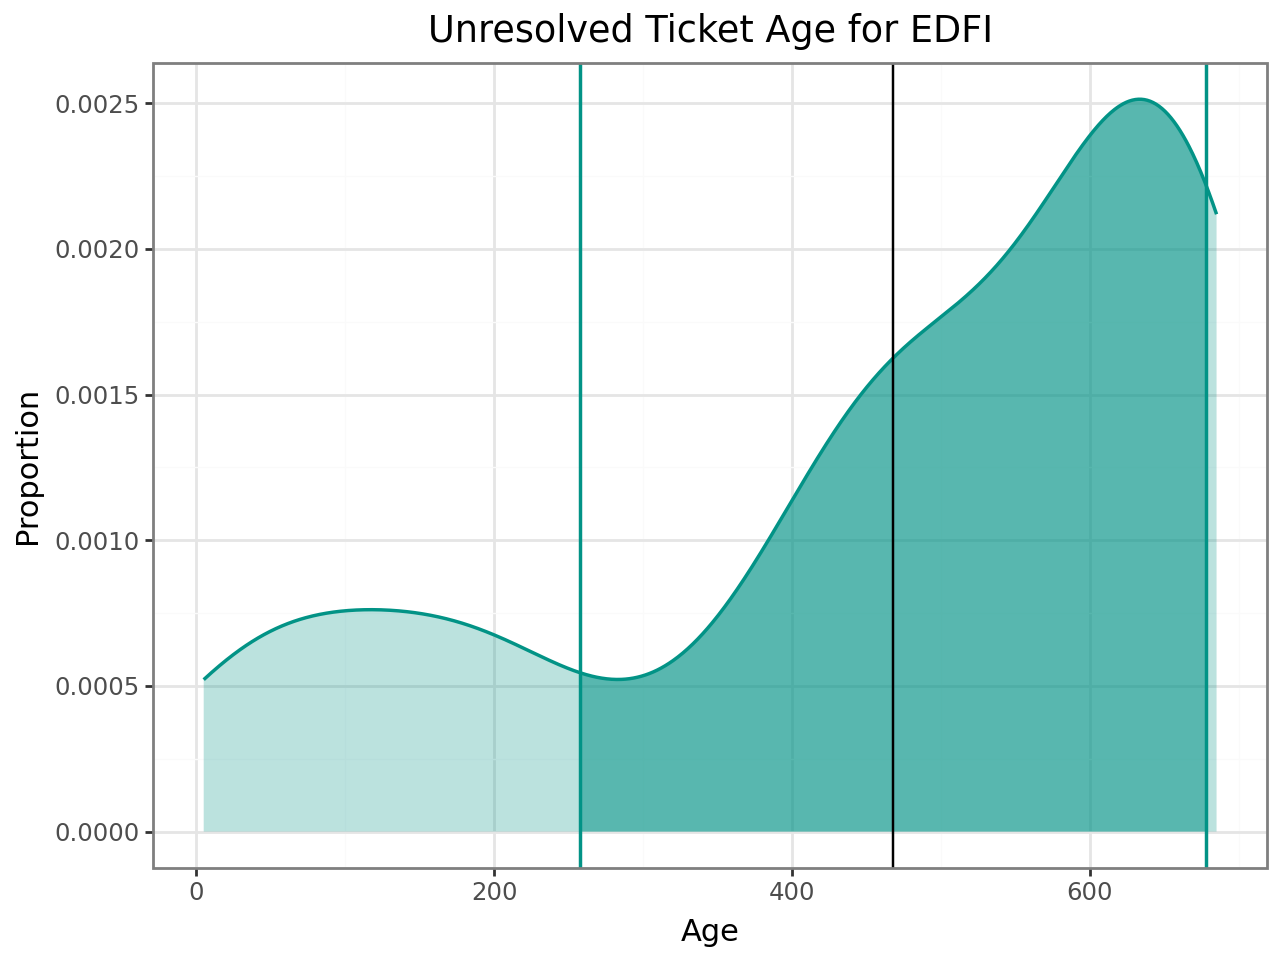

In [5]:
stats = build_report_components(projects, df)
for s in stats:
    s.histogram.show()

In [6]:
import pandas as pd
from datetime import datetime

stats_df = pd.concat([s.stats for s in stats])

today = datetime.today().strftime('%Y-%m-%d')

stats_df["date"] = today
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "project"}, inplace=True)

from pathlib import Path
Path("./data/ticket-age").mkdir(parents=True, exist_ok=True)

file_name = f"./data/ticket-age/{today}.csv"
conf.info(f"Writing age data out to file: {file_name}")
stats_df.to_csv(file_name)

stats_df

Writing age data out to file: ./data/ticket-age/2024-03-11.csv


,project,count,mean,std,min,25%,50%,75%,max,date
0,ODS,357.0,936.081232,777.106081,0.0,81.00,868.0,1692.0,2875.0,2024-03-11
1,METAED,148.0,1218.831081,1112.465854,4.0,370.00,555.0,2070.0,3188.0,2024-03-11
2,DMS,24.0,20.666667,12.239163,3.0,11.00,21.0,31.5,54.0,2024-03-11
3,ADMINAPI,568.0,180.927817,66.365936,17.0,103.00,209.0,223.0,528.0,2024-03-11
4,AA,105.0,708.657143,440.328239,66.0,312.00,551.0,1085.0,1841.0,2024-03-11
5,AC,11.0,20.727273,6.214353,11.0,16.00,24.0,26.0,26.0,2024-03-11
6,APIPUB,15.0,126.133333,113.424529,5.0,12.00,96.0,198.5,328.0,2024-03-11
7,DI,105.0,809.095238,513.914549,13.0,376.00,717.0,1106.0,1837.0,2024-03-11
8,EPPETA,24.0,117.750000,89.983694,33.0,39.00,80.5,202.0,273.0,2024-03-11
9,DATASTD,518.0,1780.444015,912.758310,11.0,1181.00,1942.0,2319.0,4067.0,2024-03-11


## Backlog Health

Enter current team average velocity over the last five sprints below:

In [21]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import pandas as pd

def get_portfolio_health(team: str, velocity: int):
    total_points = df[df["project"].isin(portfolios[team])].points.sum()

    return { 
        "points": total_points,
        "velocity": velocity,
        "health": round(total_points/velocity)
    }

df_health = None
def build_health_report(data_standard, edfi_tools, ods_platform, team_b):
    global df_health
    ds_v = float(data_standard)
    tools_v = float(edfi_tools)
    ods_v = float(ods_platform)
    b_v = float(team_b)

    health = {}
    health["Data Standard"] = get_portfolio_health("Data Standard", ds_v)
    health["Ed-Fi Tools"] = get_portfolio_health("Ed-Fi Tools", tools_v)
    health["ODS Platform"] = get_portfolio_health("ODS Platform", ods_v)
    health["Team B"] = get_portfolio_health("Team B", b_v)
    
    df_health = pd.DataFrame(health).transpose()

# Default to 1.0 to avoid temporary divide by zero
_ = widgets.interact_manual(build_health_report, data_standard="1.0", edfi_tools="1.0", ods_platform="1.0", team_b="1.0")

interactive(children=(Text(value='1.0', continuous_update=False, description='data_standard'), Text(value='1.0…

In [23]:
display(df_health)

path = "./data/backlog-health"
Path(path).mkdir(parents=True, exist_ok=True)

file_name = f"{path}/{today}.csv"
conf.info(f"Writing health data out to file: {file_name}")
df_health.to_csv(file_name)

,points,velocity,health
Data Standard,53.0,24.75,2.0
Ed-Fi Tools,266.0,28.00,10.0
ODS Platform,193.5,19.71,10.0
Team B,153.0,23.50,7.0


Writing health data out to file: ./data/backlog-health/2024-03-11.csv


## Todo

1. Account for fixed version.
   * Should we only care about age for things that are not assigned to a version? That gets to the real concern.
   * If so, that would be easy to game, with a fake fixed version (like "backlog" in MetaEd)
   * Should the health only look at items that are in fixed versions? The _next_ version perhaps?
2. Refactor to have less code visible in the notebook.